## 2020-07-01: Exploring the Probability Distribution of Exponential Moving Averages (EMAs)

### Authors
* Kevin Chu (kevin@velexi.com)

### Overview
* In this Jupyter notebook, we explore the probability distribution of exponential moving averages (EMAs).

### Definitions

Let $X = \{X_0, X_1, X_2, \ldots \}$ be a times series where $X_i$ is a random variable probability distribution $p(x)$ for all $i$. For smoothing parameter $\alpha$, define the EMAs $Y_n$ of $X$ as follows.

* $Y_0 = X_0$

* $Y_{n+1} = \alpha X_n + (1 - \alpha) Y_n$    

### Key Results
* For sufficiently large $n$, the probability distribution of $Y_n$ ranges between being similar to $p(x)$ (when $\alpha$ is near 1) and a Gaussian-like distribution (when $\alpha$ is near 0).

    * _Intuition_. $Y_n$ is mostly equal to $X_n$ when $\alpha$ is near 1, so the probability distributions of $Y_n$ and $X_n$ would be expected to be similar. When $\alpha$ is near 0, then $Y_n$ has significant contributions from all of the $X_i$. As a result, $Y_n - X_0$ is similar to the sum of i.i.d. random variables, which approaches a Gaussian for large $n$.
    
* If all of the $X_i$ are drawn from the same probability distribution, then $E[Y_n] = E[X]$.

    * If $X_0$ is drawn from a different probability distribution than the rest of the $X_i$,
      then $E[Y_n] \rightarrow E[X]$ as $n \rightarrow \infty$.
    
* As $n \rightarrow \infty$,

  $$
    Var[Y_n] \rightarrow \left( \frac{\alpha}{2 - \alpha} \right) Var[X].
  $$
  
    * This result holds regardless of whether $X_0$ is drawn from the same probability distribution as the rest of the $X_i$.
    
* "Ergodicity" appears to hold for the *probability distributions* of EMAs: the distribution of EMA values over time appears to be the same as the distribution of final EMA values over an ensemble.

### User parameters
* `num_time_points`: number of points in the time series
* `num_ensemble_samples`: number of time series to include in the ensemble
* `pdf`: probability distribution function of data samples

### History

#### 2022-05-14
- Replaced `seaborn.distplot()` with `seaborn.histplot()` because `distplot()` has been deprecated.

In [1]:
# --- User parameters

# Dataset parameters
num_time_points = 20000
num_ensemble_samples = 20000

# Probability distribution
#
# Valid options: 'uniform', 'normal', lognormal', 'exponential'
pdf = 'uniform'

In [2]:
# --- Imports

# Standard library
import time

# External packages
import matplotlib.pyplot as plt
import numba
from numba import jit
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
# --- Functions

@jit(nopython=True, nogil=True)
def compute_ema(x, alpha):
    """
    Compute exponential moving average.
    
        ema[0] = x[0]
        ema[i+1] = alpha * ema[i] + (1 - alpha) * x[i]
    
    x: numpy.ndarray
        time series data. The time index is the first index in 'x'.

    alpha: float
        weight factor
    """
    num_time_samples = x.shape[0]
    ema = np.empty(x.shape, dtype=np.float64)
    ema[0] = x[0]
    for i in range(1, num_time_samples):
        ema[i] = alpha * x[i] + (1 - alpha) * ema[i-1]
    return ema

In [4]:
# --- Test compute_ema()

# Preparations
num_time_points_test = 3
num_ensemble_samples_test = 5
alpha_test = 0.25

x_test = np.random.normal(
    size=[num_time_points_test, num_ensemble_samples_test])

# Exercise functionality
t_start = time.time()
ema = compute_ema(x_test, alpha=alpha_test)
t_end = time.time()
elapsed_time_initial = t_end - t_start

# Check results
assert (ema[0,:] == x_test[0,:]).all()
for i in range(1, num_time_points_test):
    assert np.allclose(
        ema[i,:], (alpha_test * x_test[i,:] + (1-alpha_test)*ema[i-1,:]))
    
# Verify computational performance boost from Numba
t_start = time.time()
ema = compute_ema(x_test, alpha=alpha_test)
t_end = time.time()
elapsed_time_second_call = t_end - t_start

# Print results
print("'compute_ema()' tests: PASSED")
print("Runtime 'compute_ema()' (with compilation): {:.3g}s"
      .format(elapsed_time_initial))
print("Runtime 'compute_ema()' (after compilation): {:.3g}s"
      .format(elapsed_time_second_call))

'compute_ema()' tests: PASSED
Runtime 'compute_ema()' (with compilation): 0.697s
Runtime 'compute_ema()' (after compilation): 6.48e-05s


In [5]:
# --- Preparations

# Seaborn configuration
figsize = (15, 8)
sns.set(color_codes=True)

In [6]:
# --- Generate ensemble of time series

if pdf == 'uniform':
    x = np.random.uniform(0, 1, size=[num_time_points, num_ensemble_samples])
elif pdf == 'normal':
    x = np.random.normal(size=[num_time_points, num_ensemble_samples])
elif pdf == 'lognormal':
    x = np.random.lognormal(1, 1, size=[num_time_points, num_ensemble_samples])
elif pdf == 'exponential':
    x = np.random.exponential(size=[num_time_points, num_ensemble_samples])

E[X]: 0.5
Var[X]: 0.0833


<AxesSubplot:ylabel='Density'>

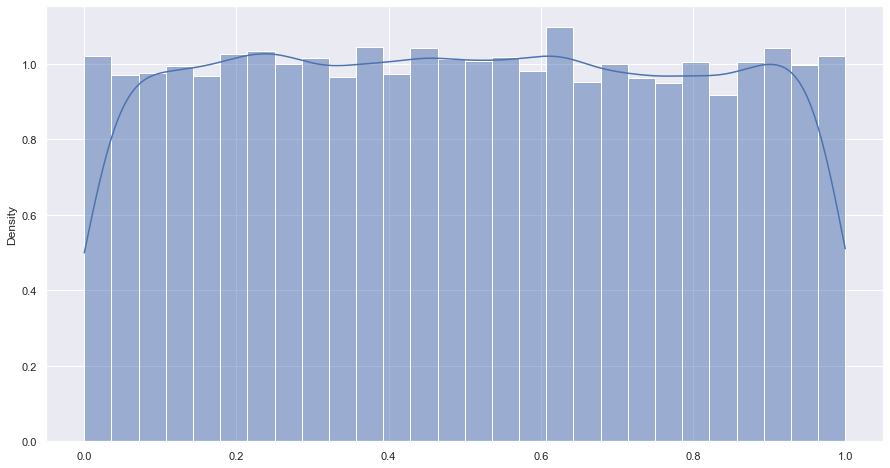

In [7]:
# --- Analyze raw data

# Compute mean and variance
x_mean = x.mean()
x_var = x.var()
print("E[X]: {:.3g}".format(x_mean))
print("Var[X]: {:.3g}".format(x_var))

# Plot probability distribution
plt.figure(figsize=figsize)
sns.histplot(x[0,:], stat='density', kde=True)

### Probability distribution of final EMA values for a large $\alpha$ value

Runtime 'compute_ema()': 1.63s
E[EMA]: 0.501
Var[EMA]: 0.0754
Asymptotic Var[EMA]: 0.0754


<AxesSubplot:ylabel='Density'>

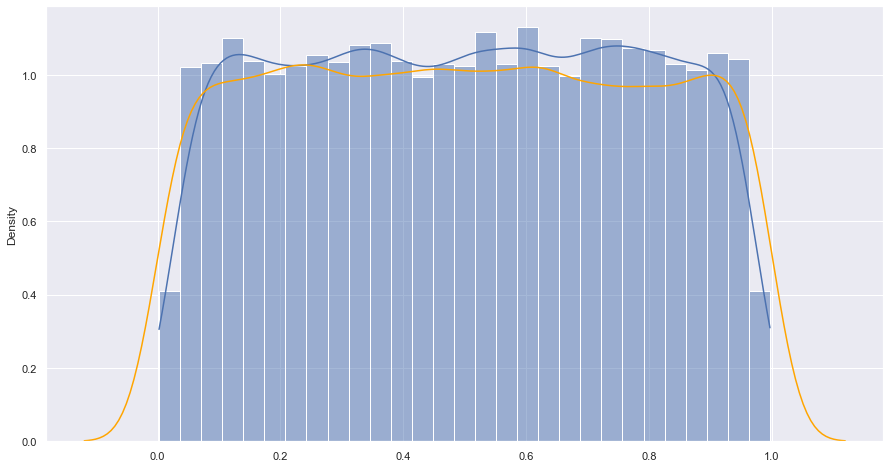

In [8]:
# Exponential Moving Average (EMA) parameters
alpha = 0.95

# Compute exponential moving averages
t_start = time.time()
ema = compute_ema(x, alpha=alpha)
t_end = time.time()
print("Runtime 'compute_ema()': {:.3g}s".format(t_end - t_start))

# Get final EMA values
ema_final = ema[-1,:]

# Compute mean and variance at end time
print("E[EMA]: {:.3g}".format(ema_final.mean()))
print("Var[EMA]: {:.3g}".format(ema_final.var()))

# Compare variance with asymptotic variance of alpha/(2 - alpha)*Var[X]
print("Asymptotic Var[EMA]: {:.3g}".format(alpha / (2 - alpha) * x_var))

# Visualize distribution at end time
plt.figure(figsize=figsize)
sns.histplot(ema_final, stat='density', kde=True)

# Compare with distribution for X
sns.kdeplot(x[0,:], color='orange')

### Probability distribution of EMA values within a single time series for large $\alpha$ value

Runtime 'compute_ema()': 0.115s
E[EMA]: 0.5
Var[EMA]: 0.0751
Asymptotic Var[EMA]: 0.0754


<AxesSubplot:ylabel='Density'>

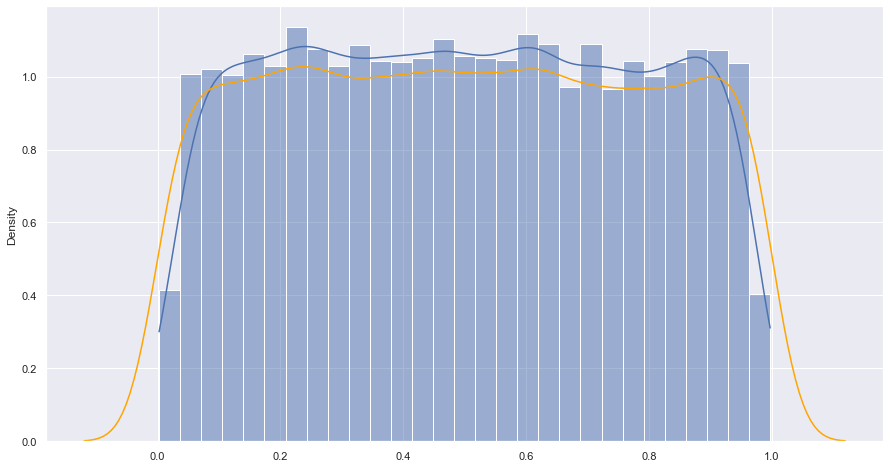

In [9]:
# Exponential Moving Average (EMA) parameters
alpha = 0.95

# Compute exponential moving averages
t_start = time.time()
ema_time_series = compute_ema(x[0,:], alpha=alpha)
t_end = time.time()
print("Runtime 'compute_ema()': {:.3g}s".format(t_end - t_start))

# Compute mean and variance of time series values
ema_mean = ema_time_series.mean()
ema_var = ema_time_series.var()
print("E[EMA]: {:.3g}".format(ema_mean))
print("Var[EMA]: {:.3g}".format(ema_var))

# Compare variance with asymptotic variance of alpha/(2 - alpha)*Var[X]
print("Asymptotic Var[EMA]: {:.3g}".format(alpha / (2 - alpha) * x_var))

# Visualize distribution of time series values
plt.figure(figsize=figsize)
sns.histplot(ema_time_series, stat='density', kde=True)

# Compare with distribution for X
sns.kdeplot(x[0,:], color='orange')

### Probability distribution of final EMA values for medium $\alpha$ value

Runtime 'compute_ema()': 3.37s
E[EMA]: 0.5
Var[EMA]: 0.0277
Asymptotic Var[EMA]: 0.0278


<AxesSubplot:ylabel='Density'>

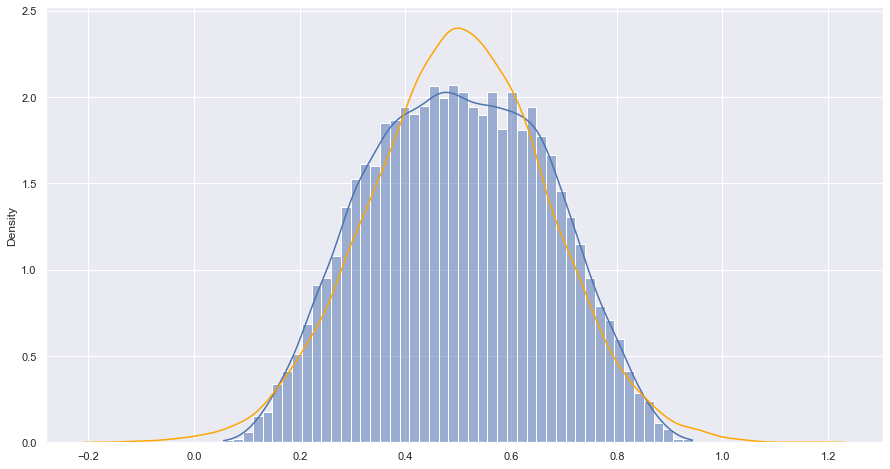

In [10]:
# Exponential Moving Average (EMA) parameters
alpha = 0.5

# Compute exponential moving averages
t_start = time.time()
ema = compute_ema(x, alpha=alpha)
t_end = time.time()
print("Runtime 'compute_ema()': {:.3g}s".format(t_end - t_start))

# Get final EMA values
ema_final = ema[-1,:]

# Compute mean and variance of final EMA values
ema_mean = ema_final.mean()
ema_var = ema_final.var()
print("E[EMA]: {:.3g}".format(ema_mean))
print("Var[EMA]: {:.3g}".format(ema_var))

# Compare variance with asymptotic variance of alpha/(2 - alpha)*Var[X]
print("Asymptotic Var[EMA]: {:.3g}".format(alpha / (2 - alpha) * x_var))

# Visualize distribution of final EMA values
plt.figure(figsize=figsize)
sns.histplot(ema_final, stat='density', kde=True)

# Compare with Gaussian distribution with parameters (mu = E[EMA], sigma^2 = Var[EMA])
g = np.random.normal(ema_mean, np.sqrt(ema_var), size=[num_ensemble_samples])
sns.kdeplot(g, color='orange')

### Probability distribution of EMA values within a single time series for medium $\alpha$ value

Runtime 'compute_ema()': 0.000244s
E[EMA]: 0.5
Var[EMA]: 0.0276
Asymptotic Var[EMA]: 0.0278


<AxesSubplot:ylabel='Density'>

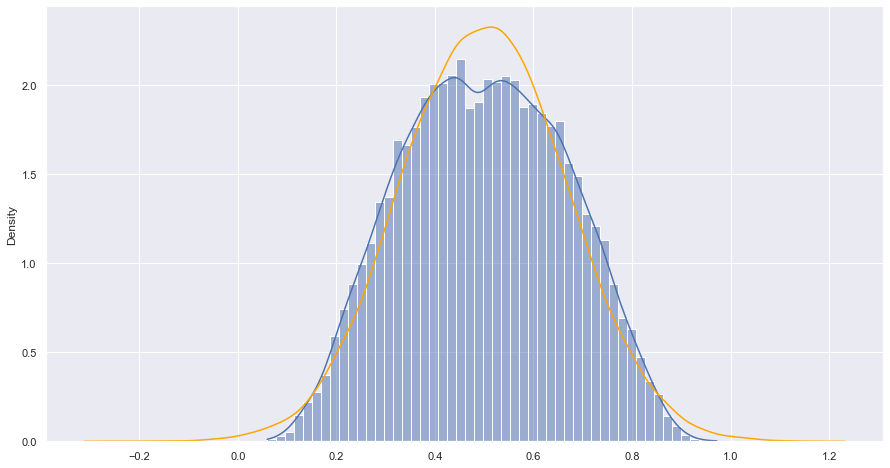

In [11]:
# Exponential Moving Average (EMA) parameters
alpha = 0.5

# Compute exponential moving averages
t_start = time.time()
ema_time_series = compute_ema(x[0,:], alpha=alpha)
t_end = time.time()
print("Runtime 'compute_ema()': {:.3g}s".format(t_end - t_start))

# Compute mean and variance of time series values
ema_mean = ema_time_series.mean()
ema_var = ema_time_series.var()
print("E[EMA]: {:.3g}".format(ema_mean))
print("Var[EMA]: {:.3g}".format(ema_var))

# Compare variance with asymptotic variance of alpha/(2 - alpha)*Var[X]
print("Asymptotic Var[EMA]: {:.3g}".format(alpha / (2 - alpha) * x_var))

# Visualize distribution of time series values
plt.figure(figsize=figsize)
sns.histplot(ema_time_series, stat='density', kde=True)

# Compare with Gaussian distribution with parameters (mu = E[EMA], sigma^2 = Var[EMA])
g = np.random.normal(ema_mean, np.sqrt(ema_var), size=[num_ensemble_samples])
sns.kdeplot(g, color='orange')

### Probability distribution of final EMA values for a small $\alpha$ value

Runtime 'compute_ema()': 2.42s
E[EMA]: 0.5
Var[EMA]: 0.00215
Asymptotic Var[EMA]: 0.00214
Approximate Asymptotic Var[EMA]: 0.00208


<AxesSubplot:ylabel='Density'>

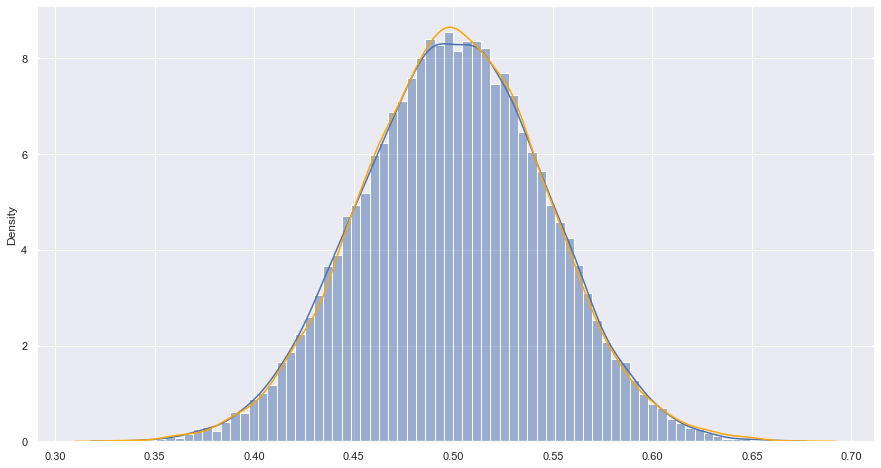

In [12]:
# Exponential Moving Average (EMA) parameters
alpha = 0.05

# Compute exponential moving averages
t_start = time.time()
ema = compute_ema(x, alpha=alpha)
t_end = time.time()
print("Runtime 'compute_ema()': {:.3g}s".format(t_end - t_start))

# Get final EMA values
ema_final = ema[-1,:]

# Compute mean and variance of final EMA values
ema_mean = ema_final.mean()
ema_var = ema_final.var()
print("E[EMA]: {:.3g}".format(ema_mean))
print("Var[EMA]: {:.3g}".format(ema_var))

# Compare variance with asymptotic variance of alpha/(2 - alpha)*Var[X]
print("Asymptotic Var[EMA]: {:.3g}".format(alpha / (2 - alpha) * x_var))
print("Approximate Asymptotic Var[EMA]: {:.3g}".format(alpha / 2 * x_var))

# Visualize distribution of final EMA values
plt.figure(figsize=figsize)
sns.histplot(ema_final, stat='density', kde=True)

# Compare with Gaussian distribution with parameters (mu = E[EMA], sigma^2 = Var[EMA])
g = np.random.normal(ema_mean, np.sqrt(ema_var), size=[num_ensemble_samples])
sns.kdeplot(g, color='orange')

### Probability distribution of EMA values within a single time series for small $\alpha$ value

Runtime 'compute_ema()': 0.000244s
E[EMA]: 0.499
Var[EMA]: 0.00225
Asymptotic Var[EMA]: 0.00214
Approximate Asymptotic Var[EMA]: 0.00208


<AxesSubplot:ylabel='Density'>

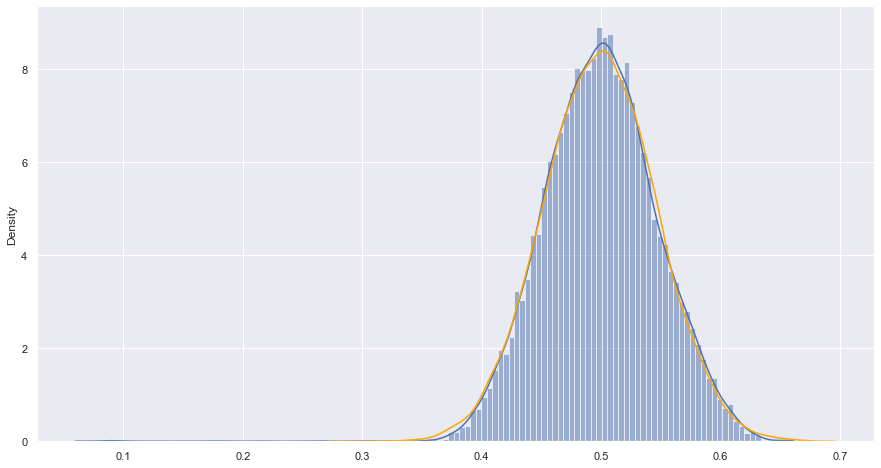

In [13]:
# Exponential Moving Average (EMA) parameters
alpha = 0.05

# Compute exponential moving averages
t_start = time.time()
ema_time_series = compute_ema(x[0,:], alpha=alpha)
t_end = time.time()
print("Runtime 'compute_ema()': {:.3g}s".format(t_end - t_start))

# Compute mean and variance of time series values
ema_mean = ema_time_series.mean()
ema_var = ema_time_series.var()
print("E[EMA]: {:.3g}".format(ema_mean))
print("Var[EMA]: {:.3g}".format(ema_var))

# Compare variance with asymptotic variance of alpha/(2 - alpha)*Var[X]
print("Asymptotic Var[EMA]: {:.3g}".format(alpha / (2 - alpha) * x_var))
print("Approximate Asymptotic Var[EMA]: {:.3g}".format(alpha / 2 * x_var))

# Visualize distribution of time series values
plt.figure(figsize=figsize)
sns.histplot(ema_time_series, stat='density', kde=True)

# Compare with Gaussian distribution with parameters (mu = E[EMA], sigma^2 = Var[EMA])
g = np.random.normal(ema_mean, np.sqrt(ema_var), size=[num_ensemble_samples])
sns.kdeplot(g, color='orange')